# 🔍 Random Forest Classification with Scikit-learn on Wine Recognition Dataset
This notebook demonstrates a complete machine learning workflow for multiclass classification using Random Forest algorithm on the Wine Recognition dataset. The project includes data loading, preprocessing, exploratory data analysis (EDA), model training with hyperparameter tuning, comprehensive evaluation with visualizations, and model persistence for future use.

In [1]:
# Cell 1: Import libraries and set global configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Cell 2: Load Wine Recognition dataset
# Load the wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target

# Create a DataFrame for easier handling
feature_names = wine_data.feature_names
target_names = wine_data.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(target_names)}")
print(f"Classes: {target_names}")
print(f"Class distribution:\n{pd.Series(y).value_counts().sort_index()}")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset shape: (178, 14)
Number of features: 13
Number of classes: 3
Classes: ['class_0' 'class_1' 'class_2']
Class distribution:
0    59
1    71
2    48
Name: count, dtype: int64

First 5 rows of the dataset:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.

In [3]:
# Cell 3: Data preprocessing
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features (though Random Forest is not sensitive to scaling, it helps with interpretation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature scaling applied: {scaler is not None}")

Missing values per column:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64
Training set size: 142
Test set size: 36
Feature scaling applied: True


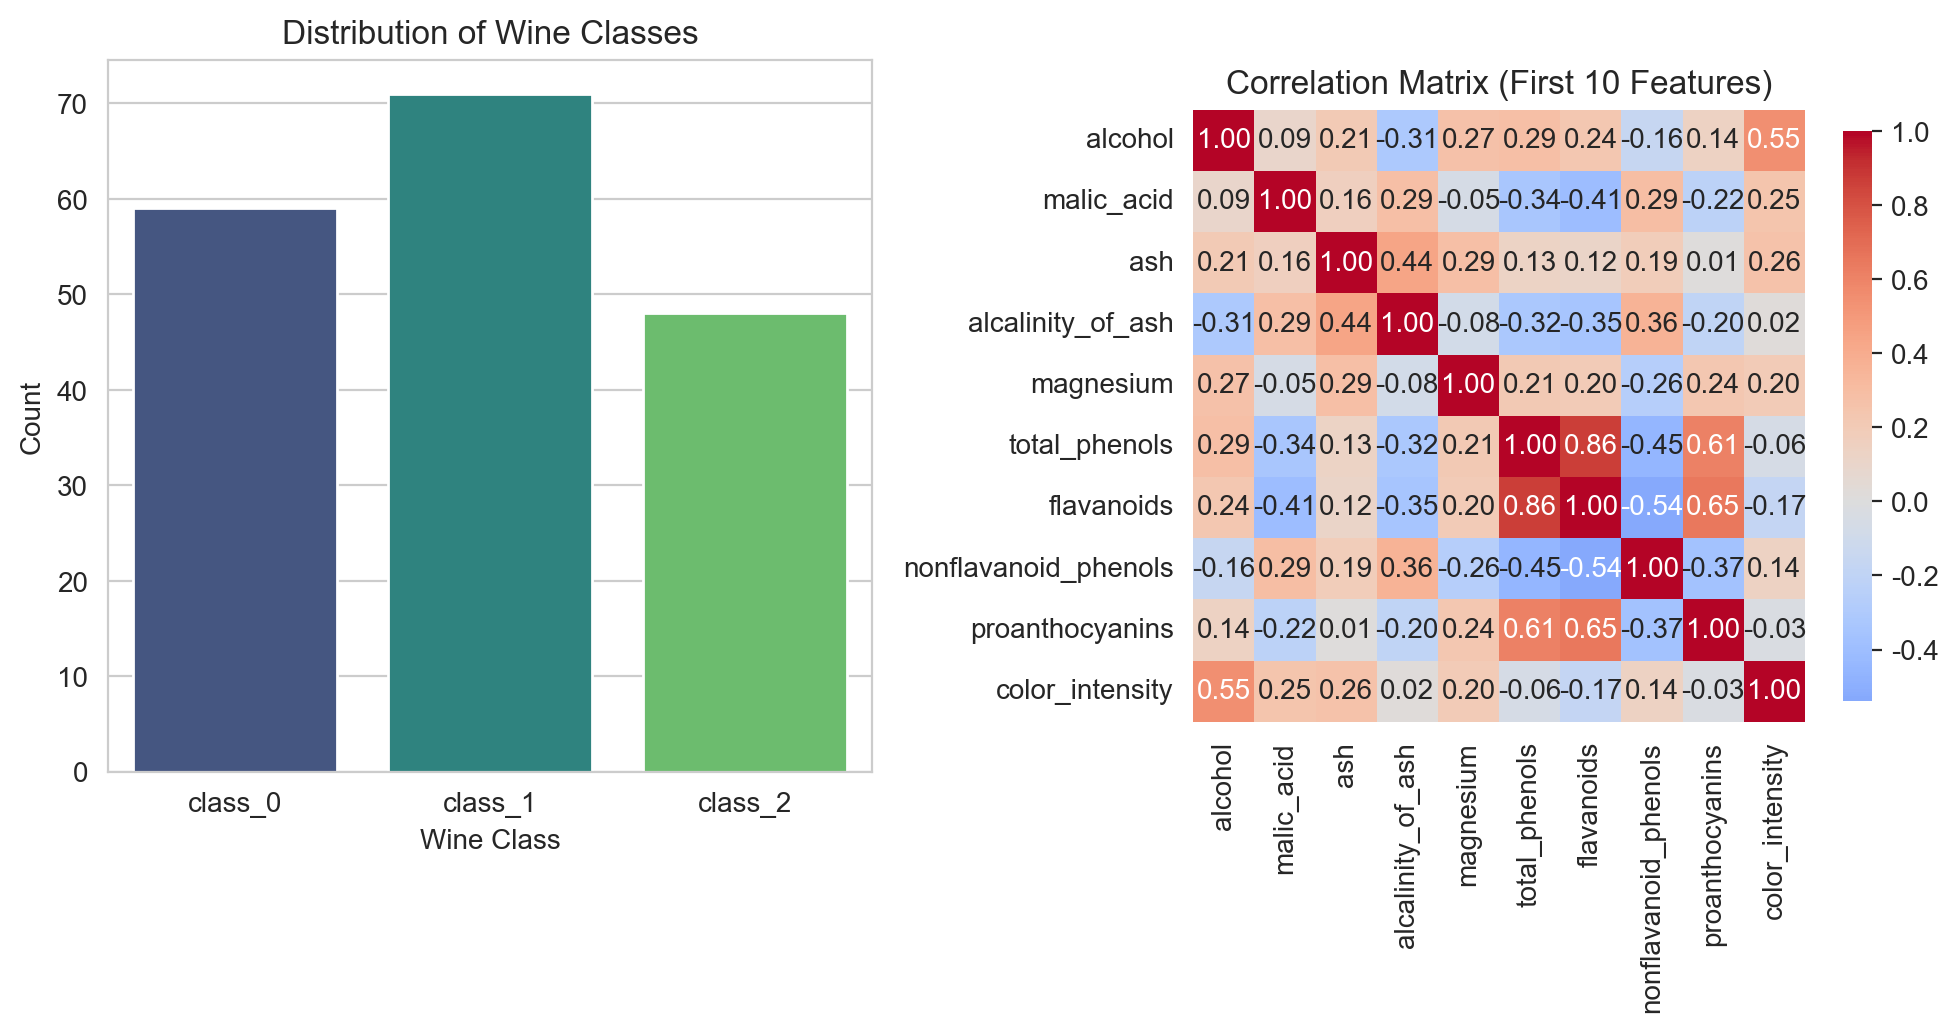

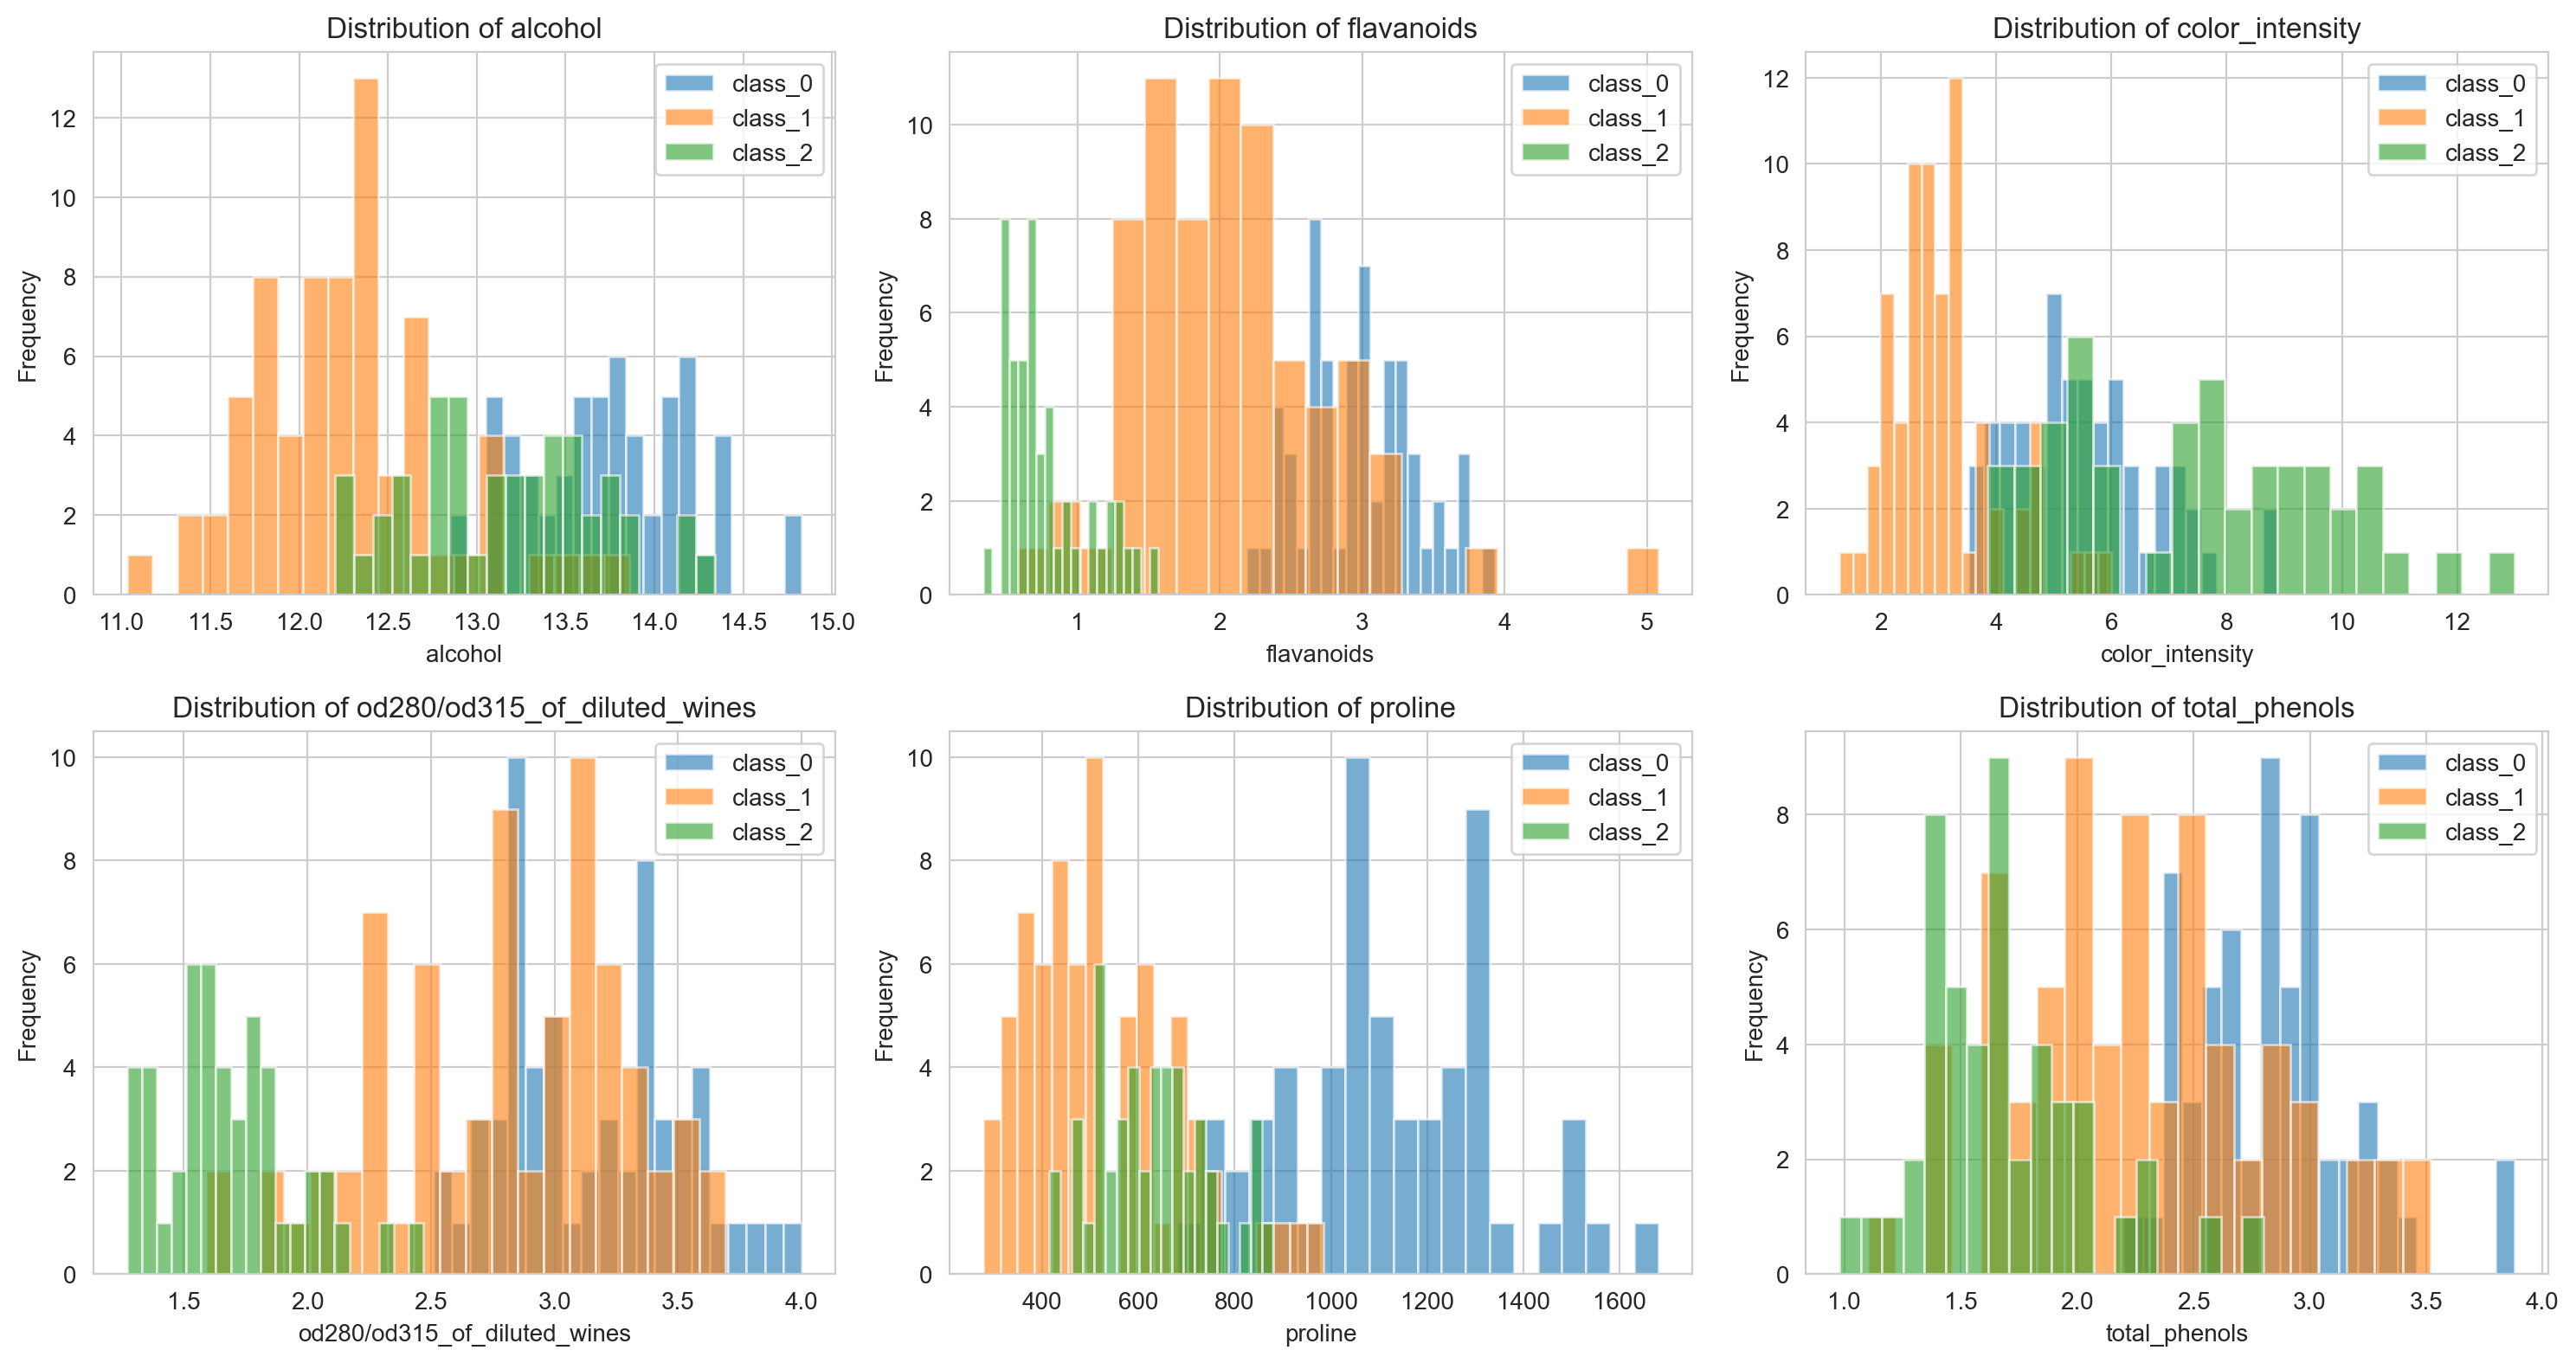

In [6]:
# Cell 4: Exploratory Data Analysis
# Visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Wine Classes')
plt.xlabel('Wine Class')
plt.ylabel('Count')
plt.xticks(range(len(target_names)), target_names)

# Correlation heatmap of features
plt.subplot(1, 2, 2)
# Select a subset of features for better visualization
subset_features = feature_names[:10]  # First 10 features
corr_matrix = df[subset_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix (First 10 Features)')
plt.tight_layout()
plt.show()

# Feature distribution by class
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
selected_features = ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline', 'total_phenols']

for i, feature in enumerate(selected_features):
    ax = axes[i//3, i%3]
    for class_idx, class_name in enumerate(target_names):
        class_data = df[df['target'] == class_idx][feature]
        ax.hist(class_data, alpha=0.6, label=class_name, bins=20)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# Cell 5: Train Random Forest model with hyperparameter tuning
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing hyperparameter tuning...")
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the model with best parameters
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Performing hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.9862
Test accuracy: 1.0000


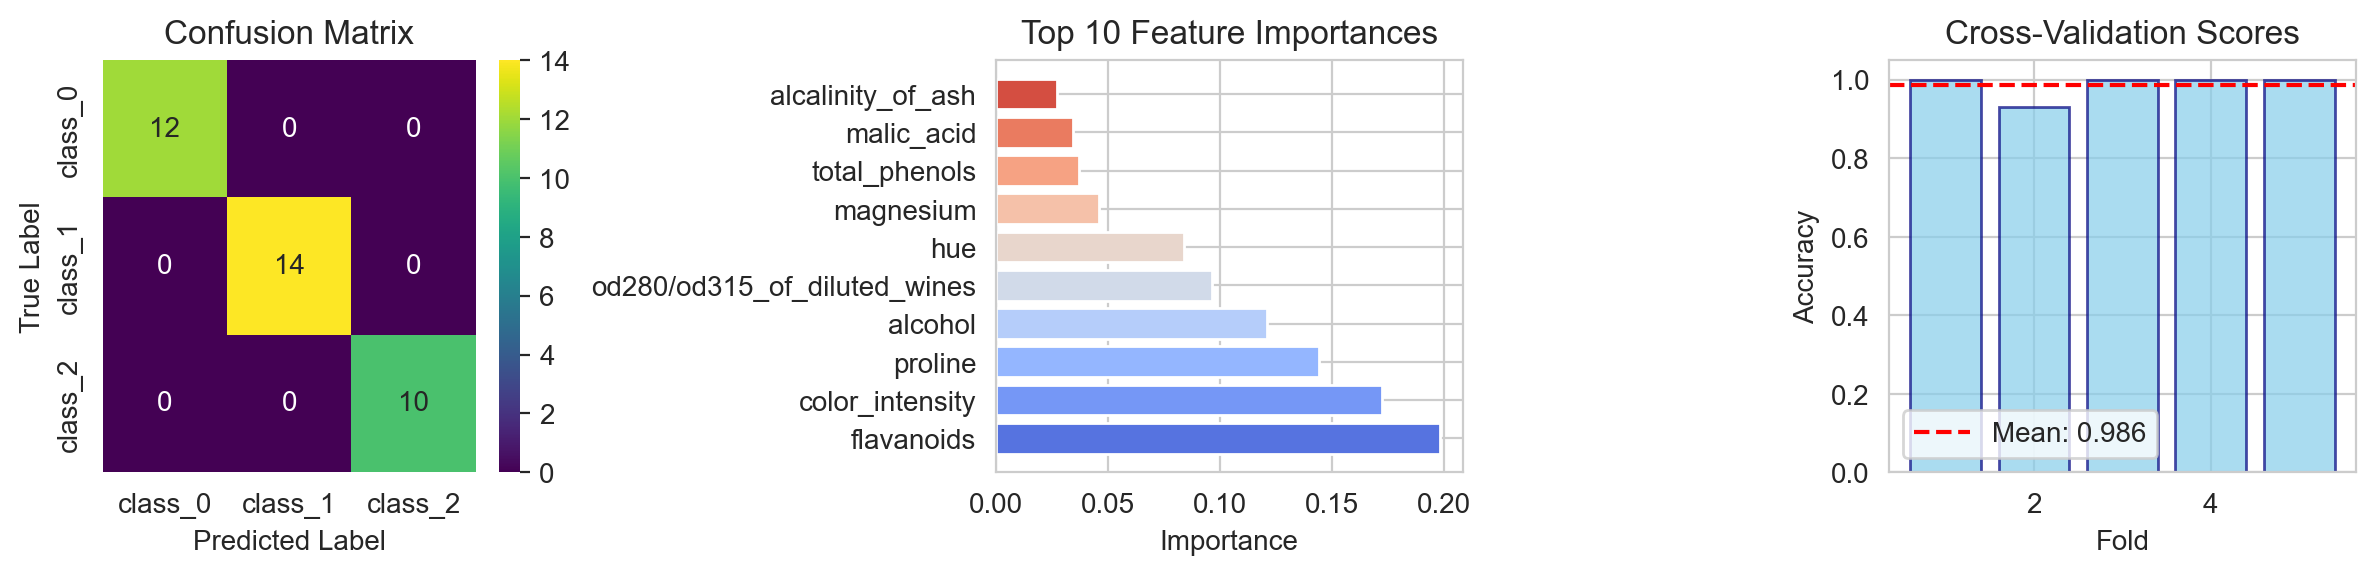


Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [10]:
# Cell 6: Visualization of results
# Confusion matrix
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Feature importance
plt.subplot(1, 3, 2)
feature_importance = best_rf_model.feature_importances_
indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

plt.barh(range(len(indices)), feature_importance[indices], color=sns.color_palette('coolwarm', len(indices)))
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')

# Cross-validation scores
plt.subplot(1, 3, 3)
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5)
plt.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))